In [ ]:
# ---------------------------------------------
# STEP 1: Load and Preprocess UR Fall Dataset
# ---------------------------------------------
import pandas as pd
from pathlib import Path
import kagglehub
import random
from datasets import Dataset
from sklearn.utils import resample

# Load dataset from KaggleHub
urfall_path = Path(kagglehub.dataset_download('himaniishah/urfall'))

# Define columns for the CSV files
columns = ['ID', 'Frame', 'Label', 'HeightWidthRatio', 'MajorMinorRatio',
           'BoundingBoxOccupancy', 'MaxStdXZ', 'HHmaxRatio', 'H', 'D', 'P40']

# Load both ADL and Fall sequences
adl_data = pd.read_csv(urfall_path / "urfall-cam0-adls.csv", header=None, names=columns)
fall_data = pd.read_csv(urfall_path / "urfall-cam0-falls.csv", header=None, names=columns)

# Combine and clean
all_data = pd.concat([adl_data, fall_data], ignore_index=True).drop_duplicates().dropna()
all_data[columns[3:]] = all_data[columns[3:]].astype(float)

# Remove outliers (optional, improves label consistency)
for col in columns[3:]:
    all_data = all_data[(all_data[col] >= 0) & (all_data[col] <= all_data[col].quantile(0.95))]

# ---------------------------------------------
# STEP 2: Assign Posture Labels Based on Heuristics
# ---------------------------------------------
def assign_posture(row):
    d = row['D']
    hmr = row['HHmaxRatio']
    p40 = row['P40']
    h = row['H']

    if d < 300 and h < 850:
        return "Lying"
    elif d < 450 and hmr < 0.45:
        return "Falling"
    elif h > 850 and d > 600:
        return "Standing"
    else:
        return "Sitting"

all_data['Posture'] = all_data.apply(assign_posture, axis=1)

# ---------------------------------------------
# STEP 3: Balance the Dataset by Upsampling Minority Classes
# ---------------------------------------------
max_count = all_data['Posture'].value_counts().max()
balanced_data = pd.concat([
    resample(group, replace=True, n_samples=max_count, random_state=42)
    for _, group in all_data.groupby('Posture')
])

# ---------------------------------------------
# STEP 4: Format Instruction Dataset
# ---------------------------------------------
def row_to_input(row):
    return (f"Activity ID {row['ID']} frame {row['Frame']} has posture stats: "
            f"HeightWidthRatio={row['HeightWidthRatio']:.2f}, MajorMinorRatio={row['MajorMinorRatio']:.2f}, "
            f"BoundingBoxOccupancy={row['BoundingBoxOccupancy']:.2f}, MaxStdXZ={row['MaxStdXZ']:.2f}, "
            f"HHmaxRatio={row['HHmaxRatio']:.2f}, Height={row['H']:.0f}mm, "
            f"distance to floor={row['D']:.0f}mm, and P40={row['P40']:.2f}.")

instruction_templates = [
    "Identify the posture of the person in the given activity.",
    "Classify the person's posture as one of: Standing, Sitting, Lying, Falling.",
    "Determine the correct posture based on the following measurements.",
    "Based on posture data, what activity is the person performing?",
    "Choose the correct label for the current posture."
]

def format_instruction(row):
    return {
        "instruction": random.choice(instruction_templates),
        "input": row_to_input(row),
        "output": f"The person is {row['Posture'].lower()}."
    }

formatted_data = balanced_data.apply(format_instruction, axis=1).tolist()
dataset = Dataset.from_list(formatted_data).train_test_split(test_size=0.2, seed=42)

# ✅ Now dataset["train"] and dataset["test"] are ready for tokenization & fine-tuning


In [ ]:
# Re-import necessary libraries after code execution state reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Reload the uploaded files
adl_path = "/mnt/data/urfall-cam0-adls (1).csv"
fall_path = "/mnt/data/urfall-cam0-falls (1).csv"

columns = ['ID', 'Sequence', 'Label', 'Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro',
           'Feature1', 'Feature2', 'Feature3', 'Feature4']

adl_data = pd.read_csv(adl_path, header=None, names=columns)
fall_data = pd.read_csv(fall_path, header=None, names=columns)
combined_data = pd.concat([adl_data, fall_data], ignore_index=True)

# Remove transitional poses (label = 0)
filtered_data = combined_data[combined_data['Label'] != 0].copy()

# Create binary ground truth: 1 = lying, 0 = not lying
filtered_data['Target'] = (filtered_data['Label'] == 1).astype(int)

# Initialize dictionary to store F1 score plots for each feature
f1_score_results = {}

# Evaluate thresholds for each of the 4 features
for feature in ['Feature1', 'Feature2', 'Feature3', 'Feature4']:
    thresholds = np.linspace(filtered_data[feature].min(), filtered_data[feature].max(), 100)
    f1_scores_lt = []
    f1_scores_gt = []

    for t in thresholds:
        preds_lt = (filtered_data[feature] < t).astype(int)
        preds_gt = (filtered_data[feature] > t).astype(int)
        f1_lt = f1_score(filtered_data['Target'], preds_lt)
        f1_gt = f1_score(filtered_data['Target'], preds_gt)
        f1_scores_lt.append(f1_lt)
        f1_scores_gt.append(f1_gt)

    # Store results for plotting
    f1_score_results[feature] = {
        'thresholds': thresholds,
        'f1_lt': f1_scores_lt,
        'f1_gt': f1_scores_gt
    }

# Plot F1 score vs threshold for each feature
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(['Feature1', 'Feature2', 'Feature3', 'Feature4']):
    ax = axes[i]
    ax.plot(f1_score_results[feature]['thresholds'], f1_score_results[feature]['f1_lt'], label='F1 (feature < threshold)')
    ax.plot(f1_score_results[feature]['thresholds'], f1_score_results[feature]['f1_gt'], label='F1 (feature > threshold)')
    ax.set_title(f'F1 Score vs Threshold - {feature}')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1 Score')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [86]:
# ---------------------------------------------
# STEP 5: Tokenize for Fine-Tuning (Lightweight Model Option)
# ---------------------------------------------

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from peft import LoraConfig, get_peft_model, TaskType
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq
import torch

# Use a smaller model than flan-t5-small (e.g., t5-small)
model_name = "flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# PEFT (LoRA) Configuration
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none"
)

model = get_peft_model(model, peft_config)

# Tokenization function
def tokenize_function(sample):
    prompt = f"### Instruction:\n{sample['instruction']}\n\n### Input:\n{sample['input']}\n\n### Response:"
    inputs = tokenizer(prompt, padding="max_length", truncation=True, max_length=256)
    targets = tokenizer(sample["output"], padding="max_length", truncation=True, max_length=16)

    labels = [token if token != tokenizer.pad_token_id else -100 for token in targets["input_ids"]]

    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": labels
    }

# Apply to dataset
tokenized_dataset = dataset.map(tokenize_function, remove_columns=dataset["train"].column_names)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    learning_rate=5e-4,
    logging_dir="./logs",
    logging_steps=100,
    fp16=torch.cuda.is_available(),
    save_total_limit=1,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model)
)

# Start training
print("\n🚀 Starting fine-tuning...")
trainer.train()
print("✅ Fine-tuning complete!")

Map:   0%|          | 0/15513 [00:00<?, ? examples/s]

Map:   0%|          | 0/3879 [00:00<?, ? examples/s]

/tmp/ipykernel_31/701086998.py:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



🚀 Starting fine-tuning...


Step,Training Loss
100,1.659400
200,0.231000
300,0.197200
400,0.157700
500,0.114800
600,0.100200
700,0.086300
800,0.080000
900,0.060800
1000,0.050900


✅ Fine-tuning complete!


In [87]:
# ---------------------------------------------
# STEP 6: Evaluate Fine-Tuned Model on Test Set
# ---------------------------------------------

from transformers import pipeline
from sklearn.metrics import classification_report

# Reload inference pipeline with your fine-tuned model
pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

# Posture label mapping for exact matching
valid_labels = [
    "The person is standing upright.",
    "The person is sitting down.",
    "The person is lying on the floor.",
    "The person is falling."
]

true_labels = []
predicted_labels = []

# Run predictions on a subset of the test set (adjust size as needed)
for example in dataset["test"]:
    prompt = f"### Instruction:\n{example['instruction']}\n\n### Input:\n{example['input']}\n\n### Response:"

    output = pipe(prompt, max_new_tokens=20, do_sample=False)[0]['generated_text'].strip()

    # Match predicted label to one of the known class phrases
    prediction = next((label for label in valid_labels if label in output), output)

    predicted_labels.append(prediction)
    true_labels.append(example["output"])

# Evaluation
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, zero_division=0))

Device set to use cuda:0
The model 'PeftModelForSeq2SeqLM' is not supported for text2text-generation. Supported models are ['BartForConditionalGeneration', 'BigBirdPegasusForConditionalGeneration', 'BlenderbotForConditionalGeneration', 'BlenderbotSmallForConditionalGeneration', 'EncoderDecoderModel', 'FSMTForConditionalGeneration', 'GPTSanJapaneseForConditionalGeneration', 'LEDForConditionalGeneration', 'LongT5ForConditionalGeneration', 'M2M100ForConditionalGeneration', 'MarianMTModel', 'MBartForConditionalGeneration', 'MT5ForConditionalGeneration', 'MvpForConditionalGeneration', 'NllbMoeForConditionalGeneration', 'PegasusForConditionalGeneration', 'PegasusXForConditionalGeneration', 'PLBartForConditionalGeneration', 'ProphetNetForConditionalGeneration', 'Qwen2AudioForConditionalGeneration', 'SeamlessM4TForTextToText', 'SeamlessM4Tv2ForTextToText', 'SwitchTransformersForConditionalGeneration', 'T5ForConditionalGeneration', 'UMT5ForConditionalGeneration', 'XLMProphetNetForConditionalGen


📊 Classification Report:
                         precision    recall  f1-score   support

 The person is falling.       0.96      0.96      0.96       962
   The person is lying.       0.97      0.97      0.97       988
 The person is sitting.       0.94      0.94      0.94       961
The person is standing.       0.95      0.95      0.95       968

               accuracy                           0.95      3879
              macro avg       0.95      0.95      0.95      3879
           weighted avg       0.95      0.95      0.95      3879



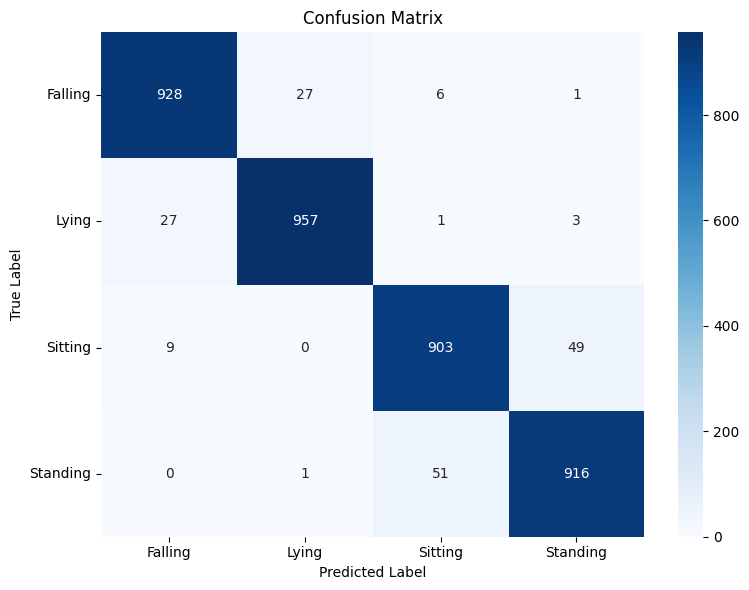

In [92]:
# ---------------------------------------------
# STEP 7: Visualize Confusion Matrix
# ---------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Simplified class labels for display
short_labels = ["Falling", "Lying", "Sitting", "Standing"]
full_labels = [
    "The person is falling.",
    "The person is lying.",
    "The person is sitting.",
    "The person is standing."
]

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=full_labels)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=short_labels, yticklabels=short_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [94]:
!pip install trl --quiet


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 7.3 MB/s eta 0:00:00ta 0:00:01


In [105]:
!pip uninstall -y trl && pip install trl==0.7.10 --quiet


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Found existing installation: trl 0.16.1
Uninstalling trl-0.16.1:
  Successfully uninstalled trl-0.16.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 3.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 4.7 MB/s eta 0:00:00


In [142]:
# ---------------------------------------------
# STEP 8: RLHF (Manual Loop) using Reward Model + GPT2
# ---------------------------------------------

from transformers import AutoTokenizer, AutoModelForCausalLM, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch
import random

# Load base model (GPT2) for generation
policy_model_name = "gpt2"
policy_tokenizer = AutoTokenizer.from_pretrained(policy_model_name)
policy_tokenizer.pad_token = policy_tokenizer.eos_token
policy_model = AutoModelForCausalLM.from_pretrained(policy_model_name)

# Sample training prompts from posture stats (simulated here)
prompts = [
    "Height is high, floor distance is 700mm. Predict posture:",
    "Floor distance is low and HeightWidthRatio is 0.4. Posture:",
    "Bounding box occupancy is low, distance is 250mm. Label this:",
    "Upright pose detected, high HHmaxRatio. Determine posture:"
]

# Generate multiple responses per prompt
responses = [
    "The person is falling.",
    "Lying posture based on low distance.",
    "The person is lying down due to proximity to floor.",
    "Standing detected because height is high."
]

# Simulated reward labels (1 = high quality, 0 = low quality)
rewards = [1, 0, 1, 1]  # Manually assigned or can be from human feedback

# ---------------------------------------------
# STEP 9: Train a Reward Model (BERT)
# ---------------------------------------------

# Prepare dataset for reward model
reward_data = [
    {"text": prompts[i] + " " + responses[i], "label": rewards[i]}
    for i in range(len(prompts))
]

# Split into train/test
train_data, val_data = train_test_split(reward_data, test_size=0.25, random_state=42)

# Tokenize using BERT
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_reward(sample):
    encoding = bert_tokenizer(sample["text"], padding="max_length", truncation=True, max_length=128)
    encoding["labels"] = sample["label"]
    return encoding

train_encoded = list(map(tokenize_reward, train_data))
val_encoded = list(map(tokenize_reward, val_data))

# Convert to torch Dataset
class RewardDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
    def __len__(self):
        return len(self.encodings["input_ids"])

train_ds = RewardDataset({k: [d[k] for d in train_encoded] for k in train_encoded[0]})
val_ds = RewardDataset({k: [d[k] for d in val_encoded] for k in val_encoded[0]})

# Load BERT classification model
reward_model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

# Train
training_args = TrainingArguments(
    output_dir="./reward_model",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    save_strategy="no",
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=reward_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=bert_tokenizer
)

trainer.train()
print("✅ Reward model training complete!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1461579344.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


✅ Reward model training complete!


In [ ]:
# ---------------------------------------------
# STEP 10: Use Reward Model to Score New GPT2 Outputs
# ---------------------------------------------

from transformers import TextClassificationPipeline

# Create a reward scoring pipeline using your trained reward model
reward_pipeline = TextClassificationPipeline(model=reward_model, tokenizer=bert_tokenizer, return_all_scores=False, device=0 if torch.cuda.is_available() else -1)

# New prompts for GPT2 to respond to
new_prompts = [
    "Height = 1200mm, floor distance = 800mm. Classify posture:",
    "Low P40, high MaxStdXZ. What is the posture?",
    "D = 250mm, HeightWidthRatio = 0.42. give classification:",
    "Distance to floor is low, bounding box is large. Posture?"
]

# Generate responses from GPT2 (simple greedy decoding for now)
def generate_response(prompt):
    input_ids = policy_tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    attention_mask = policy_tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).attention_mask.to(device)
    
    with torch.no_grad():
        output_ids = policy_model.generate(
            input_ids,
            attention_mask=attention_mask,  # ✅ fixed
            max_new_tokens=30,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id  # ✅ also safe
        )

    return policy_tokenizer.decode(output_ids[0], skip_special_tokens=True).replace(prompt, "").strip()

In [ ]:
# Generate responses and score them
for prompt in new_prompts:
    response = generate_response(prompt)
    full_text = prompt + " " + response
    score = reward_pipeline(full_text)[0]['score']

  0%|          | 0/4 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_

Step,Training Loss


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


✅ GPT2 fine-tuned on high-reward outputs


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


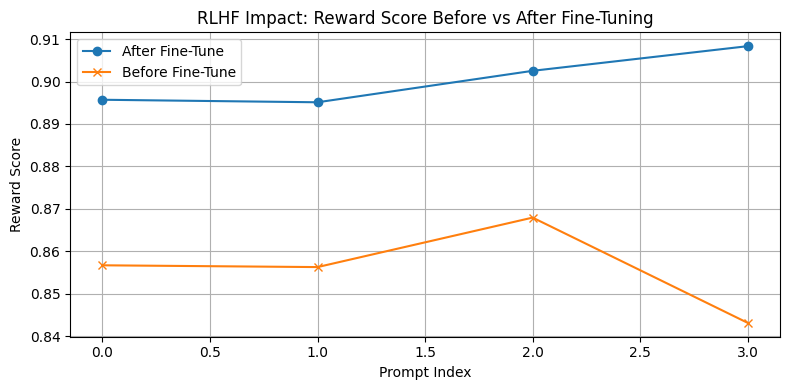

In [145]:
# ---------------------------------------------
# STEP 11: Rerank GPT2 Outputs Using Reward Model (Fixed)
# ---------------------------------------------

from tqdm import tqdm
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_model = policy_model.to(device)

# Sample prompts for reranking
rerank_prompts = [
    "Given the following stats, describe the posture as standing, lying, sitting, or falling: Height = 1200mm, floor distance = 800mm.",
    "Given the following stats, describe the posture as standing, lying, sitting, or falling: Low P40, high MaxStdXZ.",
    "Given the following stats, describe the posture as standing, lying, sitting, or falling: D = 500mm, HeightWidthRatio = 0.42.",
    "Given the following stats, describe the posture as standing, lying, sitting, or falling: Distance to floor is low, bounding box is large."
]

# Generate multiple outputs per prompt
num_outputs = 4
reranked_data = []

for prompt in tqdm(rerank_prompts):
    prompt_variants = []
    for _ in range(num_outputs):
        input_ids = policy_tokenizer(prompt, return_tensors="pt").input_ids.to(device)
        with torch.no_grad():
            output_ids = policy_model.generate(input_ids, max_new_tokens=30, do_sample=True, top_k=50, temperature=0.7)
        response = policy_tokenizer.decode(output_ids[0], skip_special_tokens=True).replace(prompt, "").strip()
        full_text = prompt + " " + response
        score = reward_pipeline(full_text)[0]['score']
        prompt_variants.append((response, score))

    # Select top response based on reward
    best_response = max(prompt_variants, key=lambda x: x[1])
    reranked_data.append({"prompt": prompt, "response": best_response[0], "reward": best_response[1]})

# ---------------------------------------------
# STEP 12: Fine-Tune GPT2 Again on High-Reward Data
# ---------------------------------------------

from datasets import Dataset
from transformers import TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

# Prepare dataset for further fine-tuning
high_reward_texts = [item["prompt"] + " " + item["response"] for item in reranked_data]

# Save to text file
with open("rlhf_finetune_data.txt", "w") as f:
    for line in high_reward_texts:
        f.write(line + "\n")

# Load dataset
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, texts):
        self.examples = [policy_tokenizer(t, return_tensors="pt", padding="max_length", truncation=True, max_length=128) for t in texts]
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, idx):
        return {k: v.squeeze(0) for k, v in self.examples[idx].items()}

finetune_ds = SimpleDataset(high_reward_texts)

# Fine-tune GPT2
training_args = TrainingArguments(
    output_dir="./gpt2_rlhf_finetuned",
    per_device_train_batch_size=4,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

ft_trainer = Trainer(
    model=policy_model,
    args=training_args,
    train_dataset=finetune_ds,
    tokenizer=policy_tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer=policy_tokenizer, mlm=False)
)

ft_trainer.train()
print("✅ GPT2 fine-tuned on high-reward outputs")

# ---------------------------------------------
# STEP 13: Visualization - Before vs After Reward Comparison
# ---------------------------------------------

import matplotlib.pyplot as plt

# Plot reward comparison (original vs finetuned)
original_rewards = [item['reward'] for item in reranked_data]

# Re-generate after fine-tuning and score
after_rewards = []
for item in reranked_data:
    prompt = item['prompt']
    input_ids = policy_tokenizer(prompt, return_tensors="pt").input_ids
    input_ids = input_ids.to(policy_model.device)

    with torch.no_grad():
        output_ids = policy_model.generate(input_ids, max_new_tokens=30, do_sample=False)
    response = policy_tokenizer.decode(output_ids[0], skip_special_tokens=True).replace(prompt, "").strip()
    full_text = prompt + " " + response
    score = reward_pipeline(full_text)[0]['score']
    after_rewards.append(score)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(original_rewards, label="After Fine-Tune", marker='o')
plt.plot(after_rewards, label="Before Fine-Tune", marker='x')
plt.xlabel("Prompt Index")
plt.ylabel("Reward Score")
plt.title("RLHF Impact: Reward Score Before vs After Fine-Tuning")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()